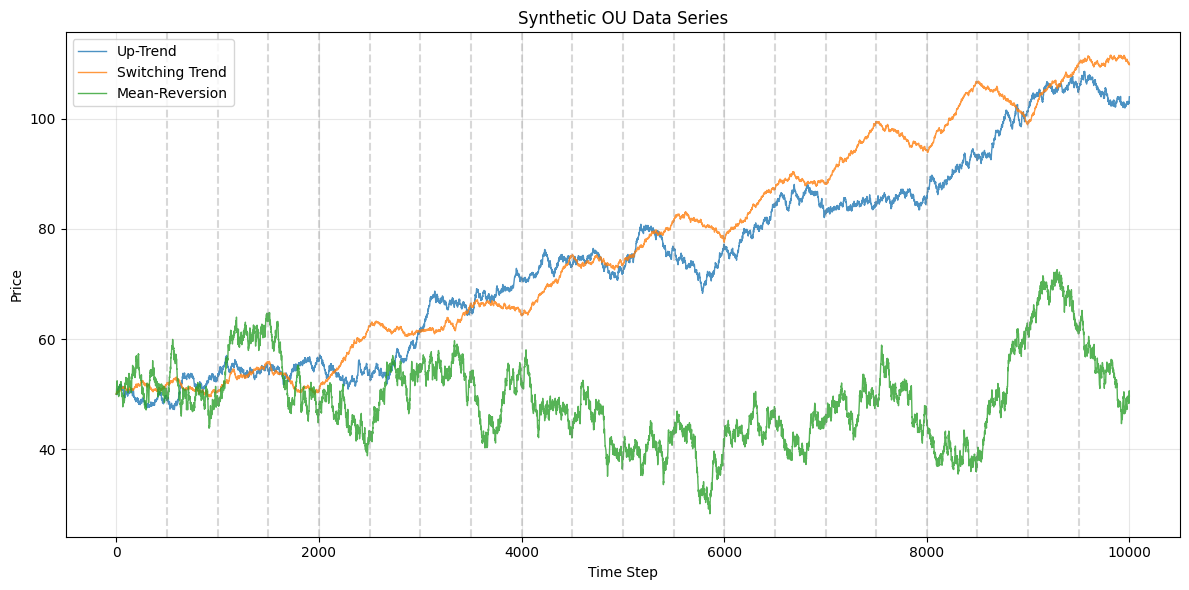

       Up-Trend range: 47.22 → 108.58
Switching Trend range: 49.56 → 111.49
 Mean-Reversion range: 28.31 → 72.61


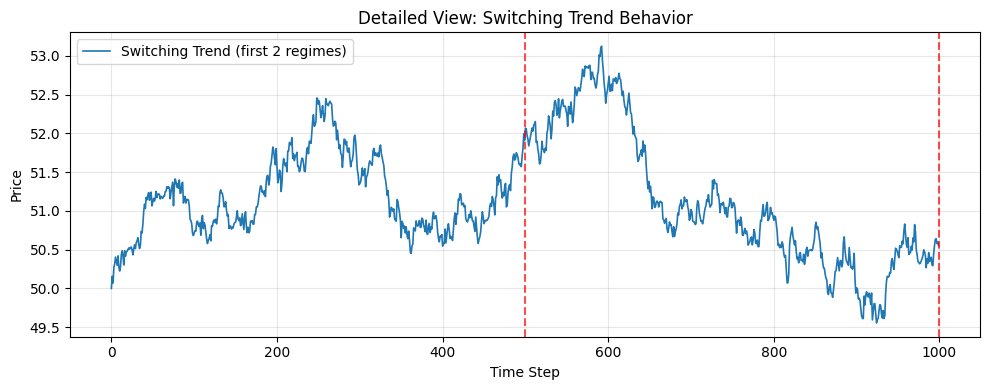

In [177]:
import torch
import matplotlib.pyplot as plt
from typing import Tuple

# ─── 1. Simulation Functions ─────────────────────────────────────────────

def simulate_ou_standard(
    mu: torch.Tensor,
    theta: float,
    sigma: float,
    dt: float
) -> torch.Tensor:
    """
    Standard Ornstein–Uhlenbeck simulation via Euler–Maruyama.
    
    Args:
      mu:    (T,) tensor of the time-varying mean μₜ
      theta: mean-reversion speed
      sigma: volatility coefficient
      dt:    time-step size
      
    Returns:
      (T,) tensor P of the simulated price path
    """
    T = mu.shape[0]
    sqrt_dt = torch.sqrt(torch.tensor(dt))
    P = torch.empty(T)
    P[0] = mu[0]
    
    for t in range(1, T):
        drift     = theta * (mu[t] - P[t-1]) * dt
        diffusion = sigma * sqrt_dt * torch.randn(())
        P[t] = P[t-1] + drift + diffusion
    
    return P


def simulate_ou_switching(
    mu: torch.Tensor,
    theta_pos: float,
    theta_neg: float,
    sigma: float,
    dt: float,
    switch_interval: int = 500
) -> torch.Tensor:
    """
    OU simulation with alternating mean-reversion speed (θ).
    
    Args:
      mu:              (T,) tensor of the always-rising mean μₜ
      theta_pos:       θ during “up” regimes
      theta_neg:       θ during “down” regimes
      sigma:           volatility coefficient
      dt:              time-step size
      switch_interval: number of steps per regime
    """
    T = mu.shape[0]
    sqrt_dt = torch.sqrt(torch.tensor(dt))
    P = torch.empty(T)
    P[0] = mu[0]
    
    for t in range(1, T):
        # flip θ every `switch_interval` steps
        theta = theta_pos if ((t // switch_interval) % 2) == 0 else theta_neg
        
        drift     = theta * (mu[t] - P[t-1]) * dt
        diffusion = sigma * sqrt_dt * torch.randn(())
        P[t] = P[t-1] + drift + diffusion
    
    return P


# ─── 2. Parameters ────────────────────────────────────────────────────────

T             = 10_000          # number of time steps
dt            = 1.0 / T         # time-step size
trend_rate    = 0.01            # pure upward drift per step
sigma_trend   = 20.0            # volatility for up-trend
sigma_flat    = 50.0            # volatility for flat mean
sigma_switch  = 10.0            # volatility for switching regime
theta_trend   = 2.0             # θ for up-trend OU
theta_flat    = 20.0            # θ for mean-reverting OU
theta_pos     = 7.5             # θ during “up” switching regimes
theta_neg     = -2.5            # θ during “down” switching regimes
regime_len    = 500             # steps per switching regime

# for reproducibility
torch.manual_seed(42)


# ─── 3. Build Mean Series ─────────────────────────────────────────────────

# 3.1 Up-trending mean: μₜ = μ₀ + trend_rate · t
mu_trend = 50.0 + trend_rate * torch.arange(T, dtype=torch.float)

# 3.2 Flat mean: μₜ = constant
mu_flat  = torch.full((T,), 50.0)

# 3.3 For switching we re-use the always-rising mean
mu_switch = mu_trend.clone()


# ─── 4. Simulate All Three Paths ─────────────────────────────────────────

P_trend  = simulate_ou_standard(mu_trend, theta_trend,   sigma_trend,  dt)
P_flat   = simulate_ou_standard(mu_flat,  theta_flat,    sigma_flat,   dt)
P_switch = simulate_ou_switching(
    mu_switch, theta_pos, theta_neg, sigma_switch, dt, switch_interval=regime_len
)


# ─── 5. Plot the Three Series ─────────────────────────────────────────────

plt.figure(figsize=(12, 6))
plt.plot(P_trend,  label="Up-Trend",         linewidth=1, alpha=0.8)
plt.plot(P_switch, label="Switching Trend",  linewidth=1, alpha=0.8)
plt.plot(P_flat,   label="Mean-Reversion",   linewidth=1, alpha=0.8)

# Add vertical lines at regime boundaries for the switching series
for k in range(1, T // regime_len):
    plt.axvline(x=k*regime_len, color="gray", linestyle="--", alpha=0.3)

plt.xlabel("Time Step")
plt.ylabel("Price")
plt.title("Synthetic OU Data Series")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


# ─── 6. Quick Diagnostics ─────────────────────────────────────────────────

def series_range(name: str, P: torch.Tensor) -> None:
    print(f"{name:>15} range: {P.min():.2f} → {P.max():.2f}")

series_range("Up-Trend",       P_trend)
series_range("Switching Trend",P_switch)
series_range("Mean-Reversion", P_flat)


# ─── 7. Zoom on First Switching Regime ────────────────────────────────────

zoom_end = 2 * regime_len
plt.figure(figsize=(10, 4))
plt.plot(P_switch[:zoom_end], label="Switching Trend (first 2 regimes)", linewidth=1.2)
for x in [regime_len, 2*regime_len]:
    plt.axvline(x=x, color="red", linestyle="--", alpha=0.7)
plt.xlabel("Time Step")
plt.ylabel("Price")
plt.title("Detailed View: Switching Trend Behavior")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
